# Unsupervised Data Exploration on Cancer Cell Line Encyclopedia (CCLE)

*Please note: This notebook uses open access data*  
*Please note: OADC Login in the BRH Profile Page needs to be authorized*    
*Please note: Graphs and vizs may not display as expected if using a ad-blocker*


Fan Wang

Principal component analysis (PCA) and t-distributed stochastic neighbor embedding (t-SNE) has become valuable tools for unsupervised data exploration. This notebook explores the application of unsupervised learning on Cancer Cell Line Encyclopedia (CCLE) gene expression profile. All results shown in this notebook are for demonstration purposes and should not be considered scientifically rigorous.

In [1]:
%%html
<script src="https://code.jquery.com/jquery-3.6.0.min.js"></script>

In [2]:
%%javascript
element.append('jQuery version: ' + jQuery.fn.jquery);

<IPython.core.display.Javascript object>

In [3]:
import gen3, operator, zipfile, scipy
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import pandas as pd
from pandas import json_normalize
from collections import Counter
from statistics import mean
from io import StringIO
from IPython.utils import io
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

#rcParams.update({"figure.autolayout": True})
#get_ipython().run_line_magic("matplotlib", "notebook")
import seaborn as sns

sns.set(style="ticks", color_codes=True)
get_ipython().run_line_magic("config", "InlineBackend.figure_format = 'png'")
import warnings

warnings.filterwarnings("ignore")
%matplotlib inline

  Using cached jupyterlab-4.0.10-py3-none-any.whl (9.2 MB)
  Using cached scipy-1.11.4-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (36.6 MB)
  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  Preparing metadata (setup.py) ... error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [15 lines of output]
      The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
      rather than 'sklearn' for pip commands.
      
      Here is how to fix this error in the main use cases:
      - use 'pip install scikit-learn' rather than 'pip install sklearn'
      - replace 'sklearn' by 'scikit-learn' in your pip requirements files
        (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
      - if the 'sklearn' package is used by one of your dependencies,
        it would be great if you take some time to track which package uses
        'sklearn' instead of 'scikit-learn' and report it to their issue tr

### Download drug response data

In [4]:
!gen3 drs-pull object dg.OADC/e8e18bb3-d66b-4232-bd27-35284c609144

{"succeeded": ["dg.OADC/e8e18bb3-d66b-4232-bd27-35284c609144"], "failed": []}


In [5]:
path_to_zip_file="OpenAccess-CCLE_structured_data.zip"

with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    zip_ref.extractall()

In [6]:
df = pd.read_csv(
    "OpenAccess-CCLE_lab_test.tsv", sep="\t", header=0
)
df["tissue"] = df["samples.submitter_id"].str.split(pat="_", n=1).str.get(1)
df["cell_line"] = df["samples.submitter_id"].str.split(pat="_", n=1).str.get(0)
df["compound"] = (
    df["submitter_id"].str.split("_response_").str.get(0).str.split("_").str.get(-1)
)

###  Visualize distribution of EC50 data for each tissue type

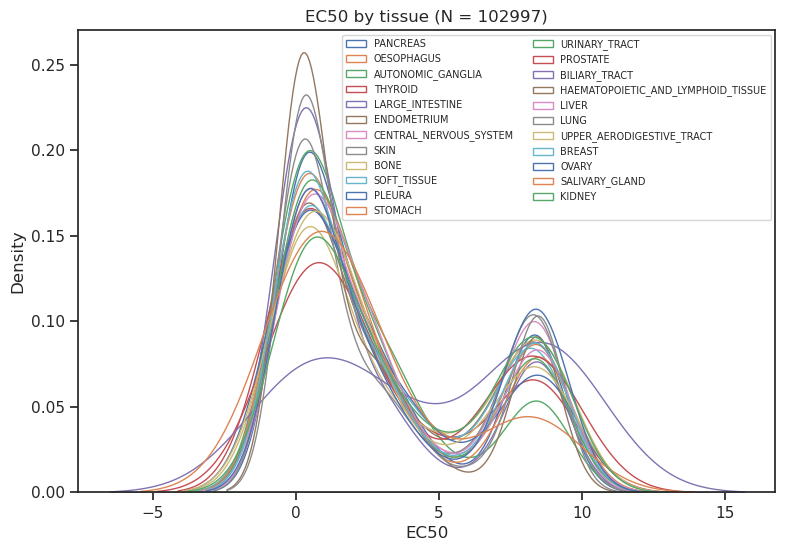

In [7]:
def plot_numeric_by_category(numeric_property, category_property, df):
    categories = list(set(df[category_property]))
    plt.figure(figsize=(9, 6), dpi=100)
    N = 0
    for category in categories:
        subset = df[df[category_property] == category]
        N += len(subset)
        data = subset[numeric_property].dropna().astype(float)
        fig = sns.kdeplot(
            df.loc[df[category_property] == category, numeric_property],
            fill=True,
            alpha=0.0,
            label=category,
        )
        plt.legend(loc="upper right", ncol=2, fontsize=7)

    plt.title(numeric_property + " by " + category_property + " (N = " + str(N) + ")")
    plt.show(fig)


numeric_property = "EC50"
category_property = "tissue"
plot_numeric_by_category(numeric_property, category_property, df)

###  Visualize distribution of EC50 data for the top 10 tissue types with the largest number of samples

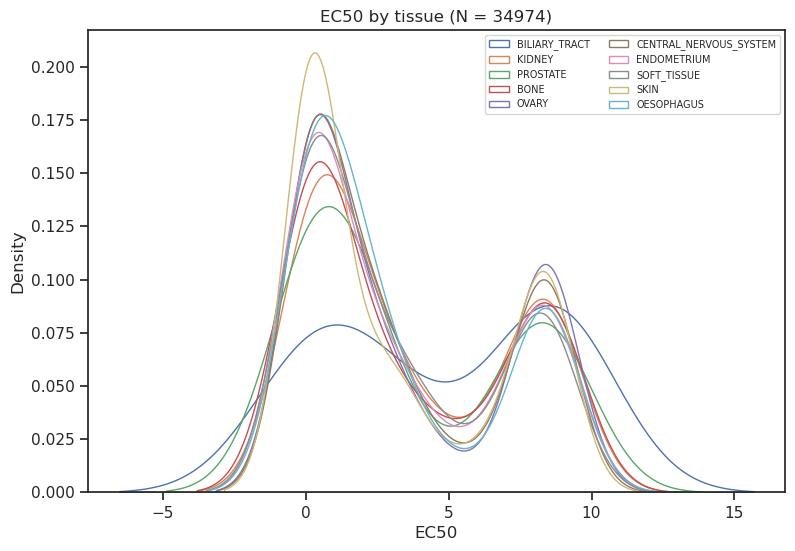

In [8]:
def plot_top10_numeric_by_category(numeric_property, category_property, df):
    categories = list(set(df[category_property]))
    plt.figure(figsize=(9, 6), dpi=100)
    category_means = {}
    for category in categories:
        df_2 = df[df[numeric_property].notnull()]
        data = list(
            df_2.loc[df_2[category_property] == category][numeric_property].astype(
                float
            )
        )

        if len(data) > 5:
            category_means[category] = mean(data)

    if len(category_means) > 1:
        sorted_means = sorted(
            category_means.items(), key=operator.itemgetter(1), reverse=True
        )[0:10]
        categories_list = [x[0] for x in sorted_means]

    N = 0
    for category in categories_list:
        subset = df[df[category_property] == category]
        N += len(subset)
        data = subset[numeric_property].dropna().astype(float)
        fig = sns.kdeplot(
            df.loc[df[category_property] == category, numeric_property],
            fill=True,
            alpha=0.0,
            label=category,
        )

        plt.legend(loc="upper right", ncol=2, fontsize=7)

    plt.title(numeric_property + " by " + category_property + " (N = " + str(N) + ")")
    plt.show(fig)


plot_top10_numeric_by_category(numeric_property, category_property, df)

### Download gene expression profile data

In [9]:
!gen3 drs-pull object dg.OADC/41c3f1ac-2cc7-4b04-b09c-a9c5dbad2c98

{"succeeded": ["dg.OADC/41c3f1ac-2cc7-4b04-b09c-a9c5dbad2c98"], "failed": []}


In [10]:
path_to_zip_file="CCLE_data_22Q2.zip"

with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    zip_ref.extractall()

In [11]:
ccle = pd.read_csv("CCLE_data_22Q2/CCLE_expression_22Q2.csv", sep=",")
ccle = ccle.rename(columns={"Unnamed: 0": "DepMap_ID"})
info = pd.read_csv("CCLE_data_22Q2/sample_info_22Q2.csv")
merge = pd.merge(info[["CCLE_Name", "DepMap_ID"]], ccle, on="DepMap_ID", how="inner")
ccle_data = merge.drop(["DepMap_ID"], axis=1)
a = ccle_data.transpose()
a = a.rename(columns=a.iloc[0])
ccle_data = a.iloc[1:, :].astype(float)
ccle_data["std"] = ccle_data.std(axis=1)
ccle_data = ccle_data.sort_values(by=["std"], ascending=False)
ccle_data = ccle_data.iloc[:100, :-1]
ccle_data_log2 = np.log2(ccle_data + 2)
merge["ccle_lineages"] = merge["CCLE_Name"].str.split(pat="_", n=1).str.get(1)
ccle_lineages = merge["ccle_lineages"].tolist()
lineage_sorted_by_count = [x[0] for x in Counter(ccle_lineages).most_common()]

### Visualize the cell lineage distribution 

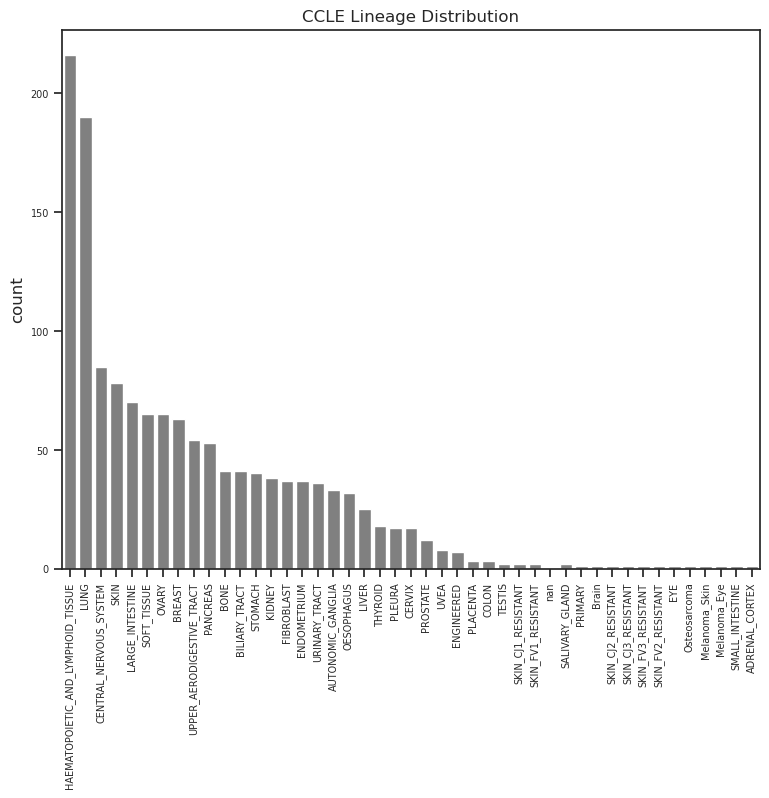

In [12]:
plt.figure(figsize=(9, 7), dpi=100)
ax = sns.countplot(x=ccle_lineages, color="gray", order=lineage_sorted_by_count)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_title("CCLE Lineage Distribution")
ax.tick_params(labelsize=7)
plt.show()

### PCA
#### We specfically focus on one cell lineage, HAEMATOPOETIC_AND_LYMPHOID_TISSUE. Below is the scatter plot of the data projected onto the first two principal components of the dataset.

#### We can see from the PCA projection that the Haematopoetic and lymphoid samples are separate from the rest of the samples in terms of their gene expression profiles.


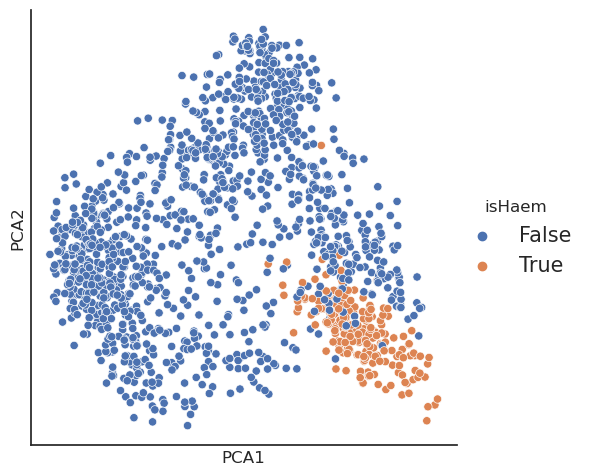

In [13]:
PCA_COMPONENTS = 10
RANDOM_SEED = 2

ccle_pca = PCA(n_components=PCA_COMPONENTS, svd_solver="full").fit_transform(
    ccle_data_log2.transpose().dropna()
)
ccle_pca_df = pd.DataFrame(data=ccle_pca)
ccle_pca_df["Lineage"] = ccle_lineages
ccle_pca_df["isHaem"] = ccle_pca_df["Lineage"] == "HAEMATOPOIETIC_AND_LYMPHOID_TISSUE"


with sns.plotting_context(rc={"legend.fontsize": 15}):
    ax = sns.relplot(x=0, y=1, data=ccle_pca_df, hue="isHaem")
    ax.set(xlabel="PCA1", ylabel="PCA2", xticks=[], yticks=[])
plt.show()

### tSNE

#### Then we run tSNE with default parameters and 4 different values of perplexity.

As perplexity decreases from 50 to 5, there are two major differences we observe in the tSNE projections:

- At a perplexity of 50 the points appear to be in two major groups whereas at a perplexity of 5 there are many more groups.1
- At a perplexity of 50 the Haem points are all in one group in one part of the plot, whereas at a perplexity of 5 they are in multiple groups spread throughout the plot.

In [ ]:
#CCLE TSNE
ccle_tsne_list = []
for PERPLEXITY in [50, 30, 10, 5]:
    this_ccle_tsne = TSNE(
        n_components=2, perplexity=PERPLEXITY, random_state=RANDOM_SEED
    ).fit_transform(ccle_pca)
    this_ccle_tsne_df = pd.DataFrame(data=this_ccle_tsne, columns=["tsne1", "tsne2"])
    this_ccle_tsne_df["Lineage"] = ccle_lineages
    this_ccle_tsne_df["isHaem"] = (
        this_ccle_tsne_df["Lineage"] == "HAEMATOPOIETIC_AND_LYMPHOID_TISSUE"
    )
    this_ccle_tsne_df["PERPLEXITY"] = PERPLEXITY
    ccle_tsne_list.append(this_ccle_tsne_df)

ccle_tsne_list_all = pd.concat(ccle_tsne_list, axis=0, ignore_index=True)


with sns.plotting_context(rc={"legend.fontsize": 15}):
    ax = sns.relplot(
        x="tsne1",
        y="tsne2",
        data=ccle_tsne_list_all,
        hue="isHaem",
        col="PERPLEXITY",
        col_wrap=2,
        col_order=[50, 30, 10, 5],
    )
    ax.set(xlabel="tSNE1", ylabel="tSNE2", xticks=[], yticks=[])
plt.show()

### Understanding tSNE behavior on CCLE

From the PCA projection we know that Haem samples are more similar to each other than to non-Haem samples. Given that there are only around 200 Haem samples, at a perplexity of 50 (which roughly means that each sample is similar to 50 other samples), tSNE basically thinks that all the Haem samples are just one big group. This is why they all appear together in the tSNE projection. But, at a perplexity of 5, tSNE realizes there are subsets of the Haem samples which are more similar to each other, which is why the Haem group is broken up into subgroups.

Now let us dive deeper to the subgroups of the Haem samples.

We see that there is structure within all the samples and substructure within the Haem samples. This makes sense with what we know about these cell lines, because the haem lineage is made of several different sublineages of the Haematopoetic lineage (eg., lymphoma, leukemia, myeloma etc).